In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import timedelta
import seaborn as sns
sns.set()

In [2]:
project_dir = "/Users/mcarb/Documents/uno/2022_spring/thesis/\
repositories/streamflow_forcasting/DailyStreamflowForecastAutoReg"
ts_dir = os.path.join(project_dir, "time_series")

yx_ts_fname = "YangXianDailyFlow1997-2014.xlsx"
zjs_ts_fname = "ZhangJiaShanDailyFlow1997-2014.xlsx"

yx_ts_path = os.path.join(project_dir, ts_dir, yx_ts_fname)
zjs_ts_path = os.path.join(project_dir, ts_dir, zjs_ts_fname)

uploaded = files.upload()

Saving ZhangJiaShanRunoff1967-2017.xlsx to ZhangJiaShanRunoff1967-2017 (2).xlsx
Saving ZhangJiaShanDailyFlow1997-2014.xlsx to ZhangJiaShanDailyFlow1997-2014 (2).xlsx
Saving YangXianRunoff1967-2014.xlsx to YangXianRunoff1967-2014 (2).xlsx
Saving YangXianDailyFlow1997-2014.xlsx to YangXianDailyFlow1997-2014 (2).xlsx
Saving Test.xlsx to Test (2).xlsx


In [130]:
df = pd.read_excel(os.path.join("/content", yx_ts_fname))
df.head()

,TM,DailyFlow,Unit,Unnamed: 3,Unnamed: 4
0,1997-01-01,60.1,m3/s,NaN,NaN
1,1997-01-02,59.9,NaN,NaN,NaN
2,1997-01-03,56.8,NaN,NaN,NaN
3,1997-01-04,51.0,NaN,NaN,
4,1997-01-05,49.3,NaN,NaN,NaN


In [131]:
df = df.iloc[:, 0:2].set_index('TM')
df.index.name = 'Date'
df.head()

,DailyFlow
Date,
1997-01-01,60.1
1997-01-02,59.9
1997-01-03,56.8
1997-01-04,51.0
1997-01-05,49.3


In [132]:
data_start_date = df.index[1]
data_end_date = df.index[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 1997-01-02 00:00:00 to 2014-12-31 00:00:00


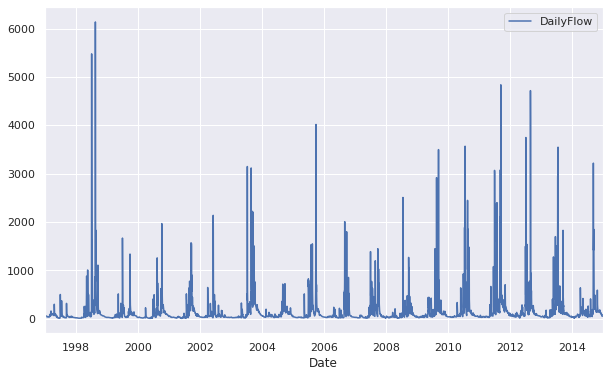

In [133]:
df.plot(figsize=(10,6))

In [134]:
pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = data_start_date 
last_day = data_end_date

# validation period includes the last day
val_pred_start = last_day - pred_length + timedelta(days=1) 
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 


In [135]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [136]:
print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 1997-01-02 00:00:00 - 2014-12-03 00:00:00
Train prediction: 2014-12-04 00:00:00 - 2014-12-17 00:00:00 

Val encoding: 1997-01-16 00:00:00 - 2014-12-17 00:00:00
Val prediction: 2014-12-18 00:00:00 - 2014-12-31 00:00:00

Encoding interval: 6545
Prediction interval: 14


In [141]:
# dates by integers
date_to_index = pd.Series(index=df.index, data=[i for i in range(len(df))])

# series by value in sequential order
series_array = df.values

# returns series by value in sequential order but for given range
def get_time_block_series(df, start_date, end_date):
    return df[start_date:end_date].values

def transform_series_encode(series_array):
    series_mean = series_array.mean()
    series_array = series_array - series_mean # sub each value by the mean
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - encode_series_mean
    
    return series_array



In [155]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

In [138]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_32 (Conv1D)          (None, None, 32)          96        
                                                                 
 conv1d_33 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_34 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_35 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_36 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_37 (Conv1D)          (None, None, 32)          2080

In [143]:
batch_size = 1
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(df, 
                                           train_enc_start,
                                           train_enc_end)
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(df, 
                                            train_pred_start,
                                            train_pred_end)
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [144]:
# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:-1, :1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history])

In [152]:
encoder_input_data = encoder_input_data.reshape(1,-1,1)

In [153]:
decoder_target_data = decoder_target_data.reshape(1,-1,1)

In [156]:
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs)

Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 105.3356
Epoch 2/10
1/1 [==============================] - 0s 17ms/step - loss: 50.2314
Epoch 3/10
1/1 [==============================] - 0s 16ms/step - loss: 24.9448
Epoch 4/10
1/1 [==============================] - 0s 16ms/step - loss: 34.6360
Epoch 5/10
1/1 [==============================] - 0s 13ms/step - loss: 23.7992
Epoch 6/10
1/1 [==============================] - 0s 13ms/step - loss: 26.9445
Epoch 7/10
1/1 [==============================] - 0s 15ms/step - loss: 23.1341
Epoch 8/10
1/1 [==============================] - 0s 13ms/step - loss: 12.1620
Epoch 9/10
1/1 [==============================] - 0s 13ms/step - loss: 19.3902
Epoch 10/10
1/1 [==============================] - 0s 14ms/step - loss: 16.9879


In [115]:
uploaded = files.upload()

In [114]:
df = pd.read_csv("/content/train_1.csv")

In [116]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


In [118]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2015-07-01 to 2016-12-31


In [119]:
from datetime import timedelta

pred_steps = 14
pred_length=timedelta(pred_steps)

first_day = pd.to_datetime(data_start_date) 
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1) 

In [120]:
enc_length = train_pred_start - first_day

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1) 

In [121]:


print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)



Train encoding: 2015-07-01 00:00:00 - 2016-12-03 00:00:00
Train prediction: 2016-12-04 00:00:00 - 2016-12-17 00:00:00 

Val encoding: 2015-07-15 00:00:00 - 2016-12-17 00:00:00
Val prediction: 2016-12-18 00:00:00 - 2016-12-31 00:00:00

Encoding interval: 522
Prediction interval: 14


In [122]:
# dates by integers
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

# series by value in sequential order
series_array = df[df.columns[1:]].values

# returns series by value in sequential order but for given range
def get_time_block_series(series_array, date_to_index, start_date, end_date):
    
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1) # row to column vector
    series_array = series_array - series_mean # sub each value by the mean
    # move values from axis 1 (2nd dim) to axis 2 (3rd dim)
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array



In [123]:
# TODO Maybe we can use the 1st dimension somehow, but it seems like we can 
# remove it.

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from tensorflow.keras.optimizers import Adam

# convolutional layer parameters
n_filters = 32 
filter_width = 2
dilation_rates = [2**i for i in range(8)] 

# define an input history series and pass it through a stack of dilated causal convolutions. 
history_seq = Input(shape=(None, 1))
x = history_seq

for dilation_rate in dilation_rates:
    x = Conv1D(filters=n_filters,
               kernel_size=filter_width, 
               padding='causal',
               dilation_rate=dilation_rate)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(1)(x)

# extract the last 14 time steps as the training target
def slice(x, seq_length):
    return x[:,-seq_length:,:]

pred_seq_train = Lambda(slice, arguments={'seq_length':14})(x)

model = Model(history_seq, pred_seq_train)

In [124]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 conv1d_24 (Conv1D)          (None, None, 32)          96        
                                                                 
 conv1d_25 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_26 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_27 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_28 (Conv1D)          (None, None, 32)          2080      
                                                                 
 conv1d_29 (Conv1D)          (None, None, 32)          2080

In [125]:
first_n_samples = 40000
batch_size = 2**11
epochs = 10

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# we append a lagged history of the target series to the input data, 
# so that we can train with teacher forcing
lagged_target_history = decoder_target_data[:,:-1,:1]
encoder_input_data = np.concatenate([encoder_input_data, lagged_target_history], axis=1)

In [127]:
encoder_input_data.shape

(40000, 535, 1)

In [129]:
decoder_target_data.shape

(40000, 14, 1)

In [55]:
model.compile(Adam(), loss='mean_absolute_error')
history = model.fit(encoder_input_data, decoder_target_data,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2)

(40000, 1)